# Previsão de preços - Airbnb RJ


### Contexto

O Airbnb é uma plataforma online de aluguel de acomodações de curto prazo em todo o mundo. Anfitriões listam suas propriedades e os viajantes podem reservar diretamente através do site ou aplicativo. Oferece variedade de opções de acomodação para diferentes orçamentos e preferências de viagem. 

Permite viver como um local, oferece espaços privados e pode ser mais econômico que hotéis. É importante verificar as políticas de cancelamento, regras da propriedade e revisões de outros usuários antes de reservar.

### Objetivo do projeto

Criar um modelo de previsão de preço para servir como base do quanto cobrar pela diária do seu imóvel e/ou verificar se o imóvel está com preço abaixo da média, tratando-se da posição de consumidor.

#### Download das bases de dados
https://www.kaggle.com/datasets/allanbruno/airbnb-rio-de-janeiro

##### Créditos:
Hashtag Treinamentos

### Importações de bibliotecas

In [140]:
import pandas as pd
import pathlib 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 
         'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
 
# Caminho das bases de dados
caminho_bases = pathlib.Path('dataset')

# Cria um dataframe vazio
base_airbnb = pd.DataFrame()

# Percorre todos os arquivos do caminho_base com o iterdir() e adiciona no df anterior
for arquivo in caminho_bases.iterdir():
    ano = int(arquivo.name[-8:-4])
    mes = meses[arquivo.name[:3]]
    
    df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)

display(base_airbnb)

In [116]:
# Realizando o data wrangling das variáveis sem utilidade
print(list(df.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Data Wrangling

In [ ]:
# Analisando as 1000 primeiras observações
base_airbnb.head(1000).to_csv('primeiras_observacoes.csv', sep=';')

In [117]:
# Analisar parcialmente a variável
print(base_airbnb[['host_is_superhost']].value_counts())
print('')
print(base_airbnb.head(100)[['host_neighbourhood']].value_counts())

host_is_superhost
f                    805893
t                     95857
dtype: int64

host_neighbourhood
Copacabana            25
Ipanema               15
Santa Teresa           9
Leblon                 7
Barra da Tijuca        6
Botafogo               6
Lapa                   4
Laranjeiras            3
Vidigal                2
Joá                    2
Flamengo               2
São Conrado            2
Santo Cristo           2
Montmartre             1
Tijuca                 1
São Cristóvão          1
Centro                 1
Gávea                  1
Maracanã               1
Humaitá                1
Consolacao             1
Lagoa                  1
Glória                 1
Leme                   1
dtype: int64


In [118]:
# Verificar se duas variáveis são idênticas:
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
dtype: int64


In [119]:
# Verificando o número de células vazias para tomada de decisão de exclusão
total = base_airbnb['id'].count() 
vazias = base_airbnb['square_feet'].isnull().sum()
dif = total - vazias

print(total,'│', vazias,'│', dif)

902210 │ 888162 │ 14048


In [120]:
# Após a limpeza das colunas que não serão necessárias, iremos informar ao python somente as que queremos manter:

df_ajustado = pd.read_csv(r'primeiras_observacoes.csv', sep=";")

# Extrair as colunas da nova base de dados
colunas = [coluna for coluna in df_ajustado.columns]
print(colunas,'\n')
print('Foram importadas {} variáveis'.format(len(colunas)))

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes'] 

Foram importadas 34 variáveis


In [121]:
# Informar ao pandas que queremos somente as colunas informadas anteriormente, na base original

base_airbnb = base_airbnb.loc[:,colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


In [122]:
# Tratamento dos valores faltante por coluna

print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [123]:
# Não manteremos as colunas com valores superiores a 300000.

# O loop percorre todas as colunas e conta a quantidade de Nan, se for superior a 300k a coluna é removida da base
for coluna in base_airbnb.columns:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
        
print(base_airbnb.isnull().sum(),'\n')
print(base_airbnb.shape)

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64 

(902210, 23)


In [124]:
# Realizaremos a exclusão das linhas Nan, pois a relação entre a quantidade e o total da base é considerável e não irá influenciar

base_airbnb = base_airbnb.dropna()
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64
(897709, 23)


In [125]:
# Verificando e corrigindo os tipos de dados
print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       1.0
la

In [133]:
# Alterando os tipos de dados

#price > object > float32
base_airbnb['price'] = base_airbnb['price'].replace('$', '')
base_airbnb['price'] = base_airbnb['price'].replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#extra_people > object > float32
base_airbnb['extra_people'] = base_airbnb['extra_people'].replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


<AxesSubplot:>

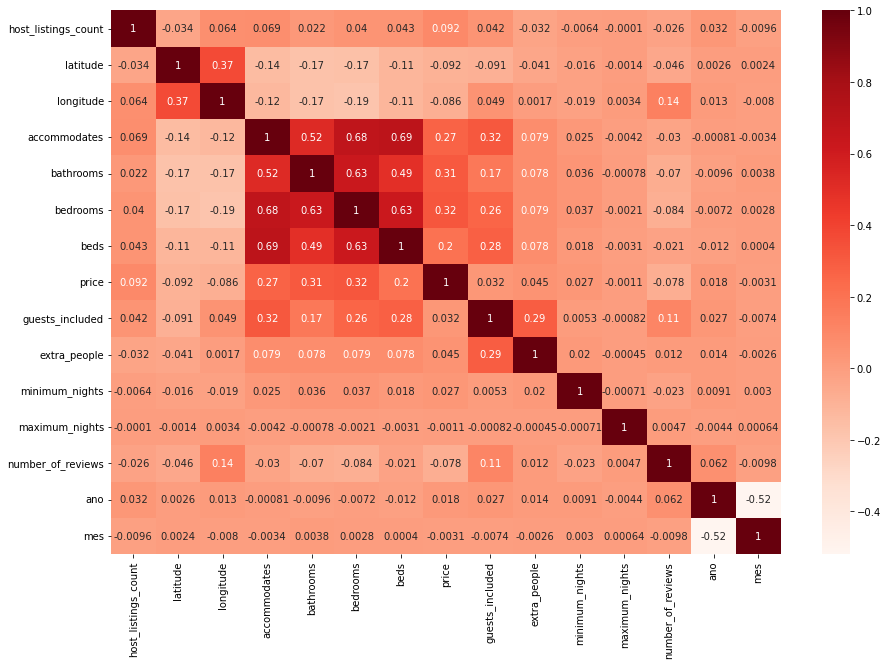

In [142]:
# Definir tamanho do gráfico
plt.figure(figsize=(15,10))

# Plotagem
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Reds')
